# 🧭 1. Business Problem Framing

Inventory management plays a crucial role in optimizing supply chain performance.
Accurate forecasting of stock levels helps businesses minimize carrying costs, avoid stockouts, and improve fulfillment efficiency.

This project focuses on developing a data-driven inventory forecasting solution capable of predicting daily inventory levels for the next six months.

Multiple time series forecasting models to explore:

ARIMA (AutoRegressive Integrated Moving Average)

SARIMA (Seasonal ARIMA)

Prophet (Additive Model for Trend and Seasonality)


🎯** Project Objective**

The objectives of this project are to:

1. Perform Exploratory Data Analysis (EDA) to understand trends, seasonality, and stationarity of inventory data.

2. Build and compare forecasting models (ARIMA, SARIMA, and Prophet) to identify the most accurate and reliable method.

3. Evaluate model performance using statistical metrics (MAE, RMSE, MAPE, R²).

4. Select and deploy the best-performing model for forecasting 180 future days of inventory levels.

5. Enable interactivity through a dashboard where users can visualize, upload data, and download forecast results.

#1- Install Required Libraries

In [ ]:

# Import necessary libraries
!pip install prophet
!pip install statsmodels

In [ ]:


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


#2- Load and Prepare the Data

In [ ]:
#Load dataset
Original_data = pd.read_excel('inventory_ts.xlsx')

In [ ]:
#load dataset sheet 'FactInventory copy
df=pd.read_excel('inventory_ts.xlsx')

In [ ]:
#Visaulize first rows of the dataset
df.head()

,Date,ClosingStock
0,2020-01-01,510
1,2020-01-02,499
2,2020-01-03,516
3,2020-01-04,534
4,2020-01-05,500


In [ ]:
df.shape

(1827, 2)

In [ ]:
#Veriry null values
df.isnull().sum()

,0
Date,0
ClosingStock,0


In [ ]:
#Verify duplicates
df.duplicated().sum()

0

In [ ]:
#General info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1827 non-null   datetime64[ns]
 1   ClosingStock  1827 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 28.7 KB


# 3- Exploratory Data Analysis (EDA)


In [ ]:
#Make the necessary convertions to work with the dataset
Original_data['Date'] = pd.to_datetime(Original_data['Date'])
Original_data.set_index('Date', inplace=True)
Original_data.sort_index(inplace=True)


/tmp/ipython-input-135018340.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stock = Original_data['ClosingStock'].resample('M').last()


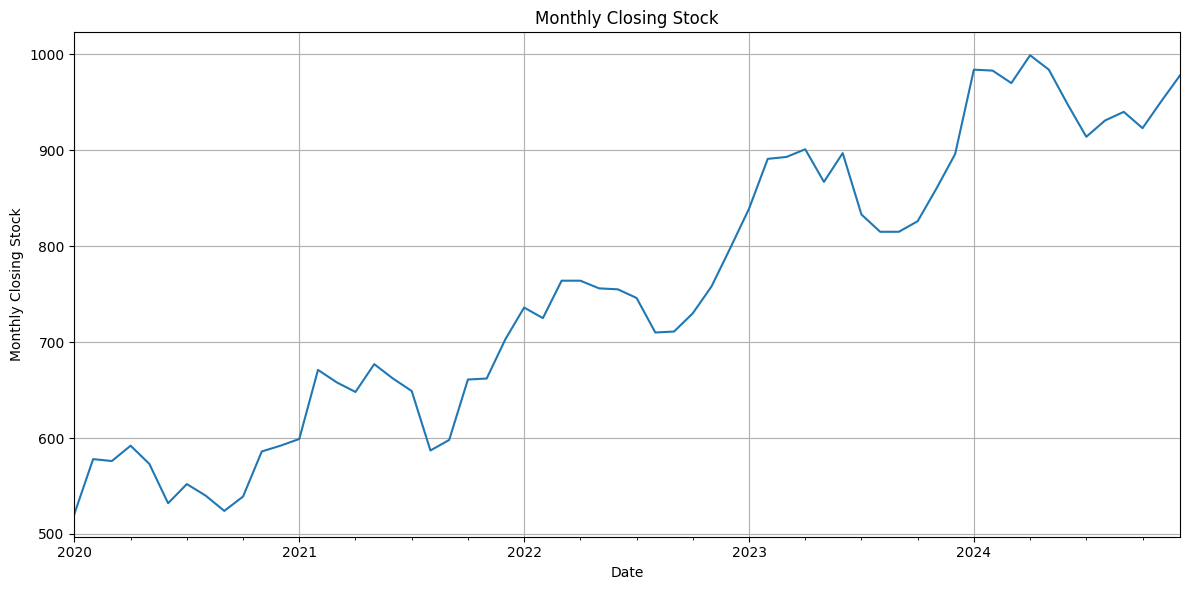

In [ ]:
# 3. 📅 Monthly Seasonality
monthly_stock = Original_data['ClosingStock'].resample('M').last()
monthly_stock.index = monthly_stock.index.to_period('M')
#month_plot(monthly_stock, ylabel='Monthly Closing Stock') # Removed the call to the undefined function
plt.figure(figsize=(12, 6)) # Added a figure for the plot
monthly_stock.plot(ylabel='Monthly Closing Stock') # Plot the monthly stock data directly
plt.title('Monthly Closing Stock') # Added a title for clarity
plt.grid()
plt.tight_layout()
plt.show()

Observations:

- Monthly averages are fairly stable, around 720–780 units, except in year-end (slight rise to ~790).

- Inventory levels rise sharply at the beginning of each year, then decline mid-year before picking up again around November–December.

- The peaks (black lines reaching above 900–1000 units) happen around January to April.

- The troughs fall around August–September, dipping close to 700 or below.

NOTE:
Each black line shows inventory variation within the year, and the red bars represent the average monthly inventory level.


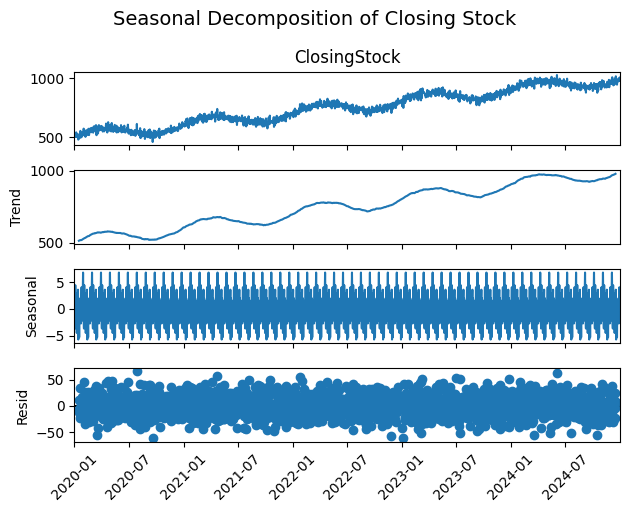

In [ ]:
# 4. 🔍 Seasonal Decomposition
decomposition = seasonal_decompose(Original_data['ClosingStock'], model='additive', period=30)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Closing Stock', fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Observations:

- Overall upward drift from ~2020 to 2024, suggesting inventory growth over time.

- Strong, consistent annual cycles.


Note: The data is non-stationary because both the level and variance change over time.

In [ ]:
#Pivot table for montly closing detail
monthly_closingstock_across_years = pd.pivot_table(Original_data, values = 'ClosingStock', columns = Original_data.index.month, index = Original_data.index.year)
monthly_closingstock_across_years

Date,1,2,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,
2020,512.967742,544.931034,568.064516,576.166667,569.580645,562.866667,543.645161,526.032258,519.900000,532.290323,557.966667,581.419355
2021,619.451613,651.750000,662.387097,674.800000,671.225806,651.333333,641.032258,628.225806,626.200000,629.000000,651.366667,679.645161
2022,714.806452,751.964286,768.806452,778.666667,776.290323,768.333333,741.516129,730.451613,719.333333,736.967742,753.633333,784.161290
2023,822.612903,846.714286,869.903226,873.866667,875.032258,859.300000,840.580645,827.580645,816.533333,834.161290,855.833333,890.387097
2024,916.903226,954.000000,966.645161,972.733333,968.032258,963.100000,943.451613,931.677419,925.866667,932.935484,949.500000,978.096774


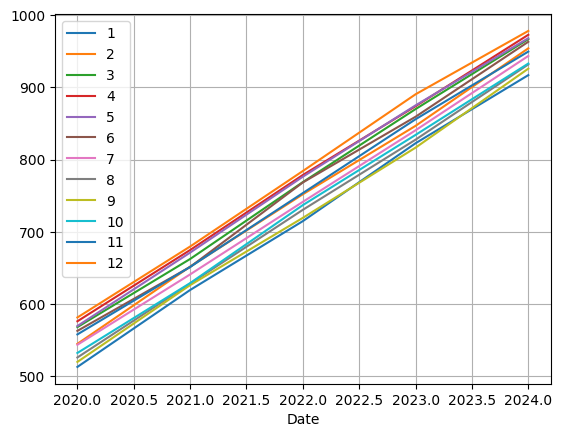

In [ ]:
monthly_closingstock_across_years.plot()
plt.grid()
plt.legend(loc='best');

Observations:

 - 1. Seasonal Inventory Patterns
    The line plot shows distinct monthly fluctuations in closing stock levels.

 - 2. Year-over-Year Inventory Growth
    The pivot table reveals a steady increase in closing stock from 2022 to 2025.
 - 3. Volatility Signals
    Some months show sharp changes in stock levels year-over-year, - Months like January, August, and December exhibit higher variability.




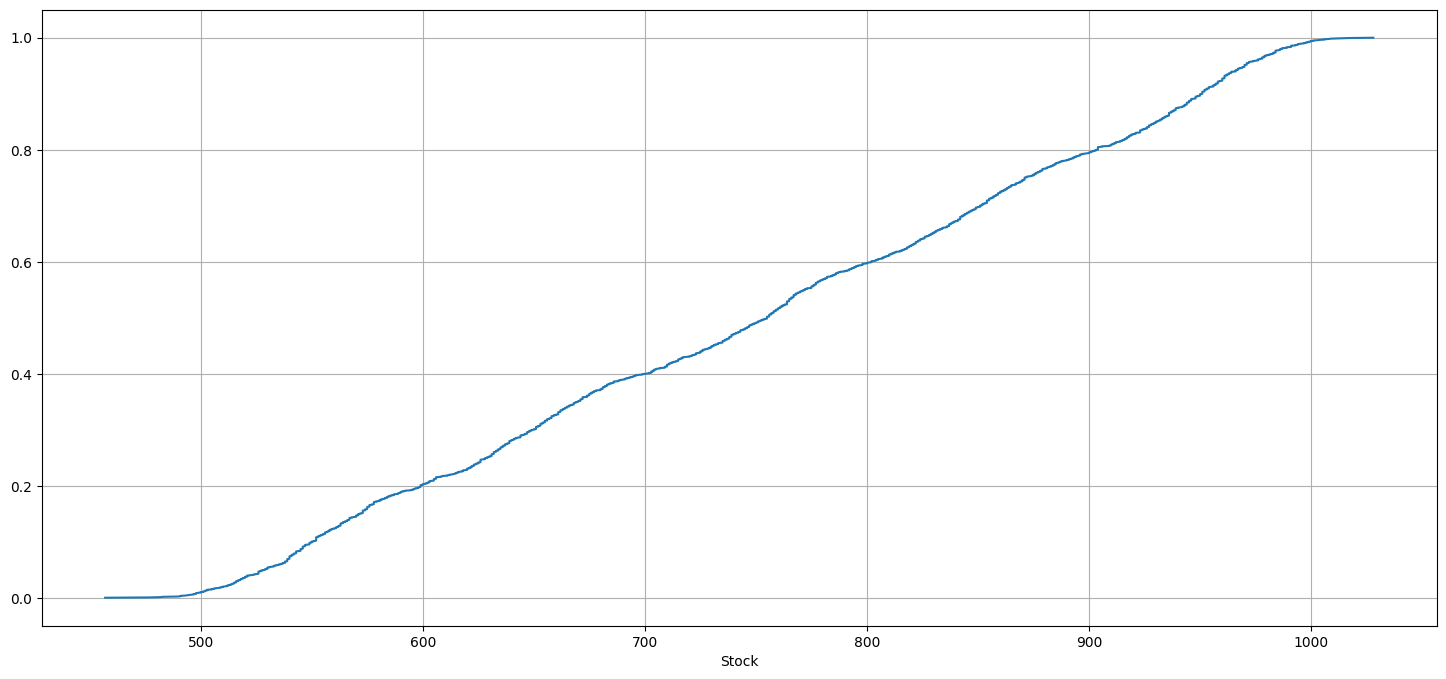

In [ ]:
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize = (18, 8))
cdf = ECDF(Original_data['ClosingStock'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.grid()
plt.xlabel('Stock');

Overvations:
- The ECDF curve appears smooth and steadily increasing, which implies:
- Stock levels are evenly distributed across time.
- There are no extreme outliers or sudden jumps in inventory.


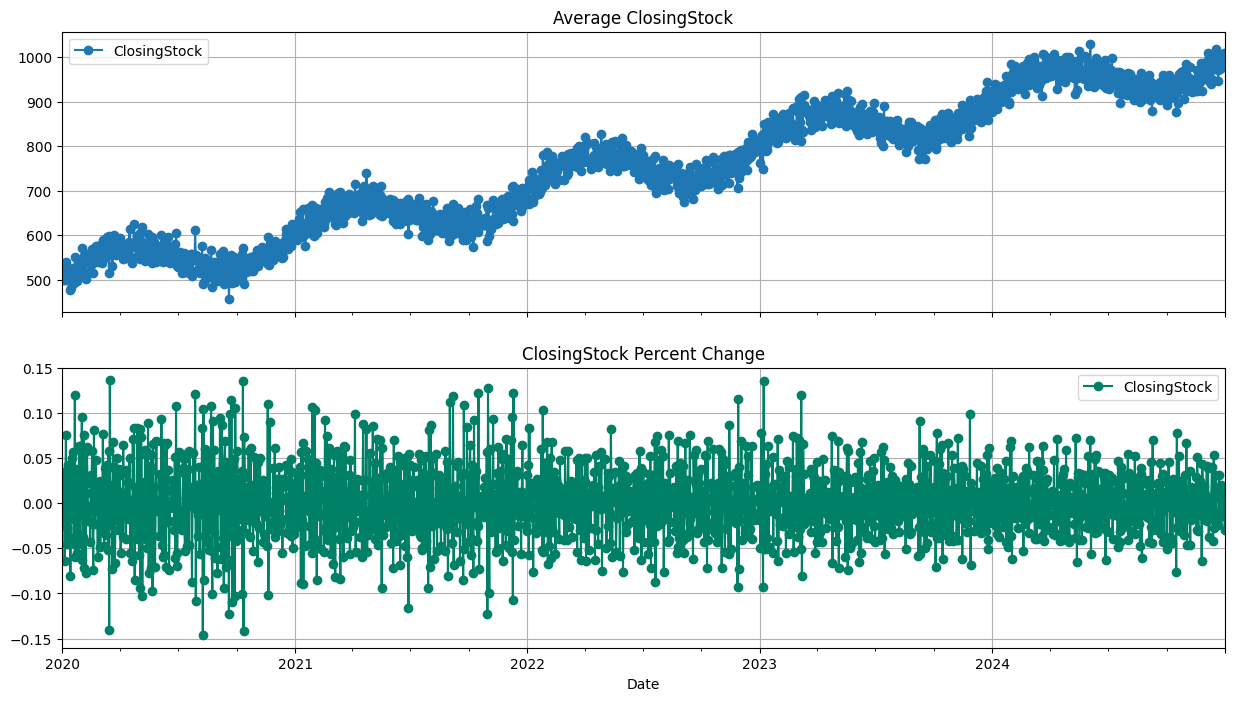

In [ ]:
#Plot the average ClosingStock per month and the month on month percentage change of ClosingStock.
# group by date and get average RetailSales, and precent change
average    = Original_data.groupby(Original_data.index)["ClosingStock"].mean()
pct_change = Original_data.groupby(Original_data.index)["ClosingStock"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average RetailSales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average ClosingStock",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for Closingstock over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="ClosingStock Percent Change",grid=True)

Observations:

1. Average Closing Stock Over Time
- The left plot shows a cyclical pattern in average monthly closing stock.
- Peaks and troughs suggest seasonal stocking behavior—possibly aligned with promotional cycles or demand surges.
- The upward trend from early 2022 to mid-2023 reflects inventory growth

2. Month-on-Month Percent Change
- The right plot reveals sharp spikes and drops, indicating:
- Reactive inventory adjustments (e.g., sudden restocking or depletion)
- Volatility in demand or supply


Decompose the Time Series and plot the different components.

In [ ]:
from    statsmodels.tsa.seasonal import   seasonal_decompose

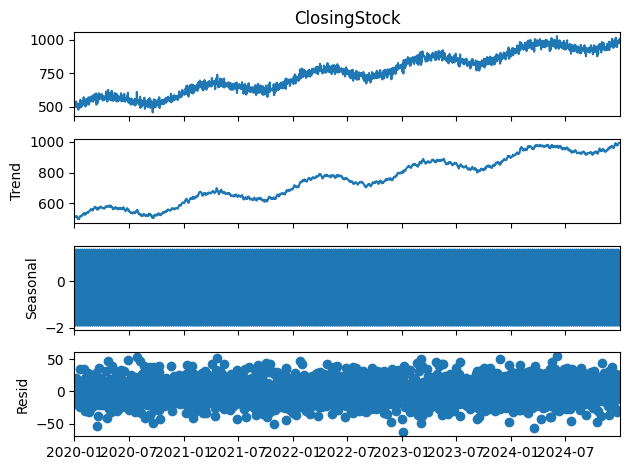

In [ ]:
decomposition = seasonal_decompose(Original_data['ClosingStock'],model='additive')
decomposition.plot();

In [ ]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Date
2020-01-01           NaN
2020-01-02           NaN
2020-01-03           NaN
2020-01-04    514.142857
2020-01-05    516.142857
2020-01-06    516.285714
2020-01-07    517.000000
2020-01-08    512.428571
2020-01-09    512.857143
2020-01-10    515.428571
2020-01-11    506.571429
2020-01-12    500.571429
Name: trend, dtype: float64 

Seasonality 
 Date
2020-01-01    1.355033
2020-01-02    0.079758
2020-01-03   -1.264198
2020-01-04    1.304420
2020-01-05   -1.909803
2020-01-06   -0.052110
2020-01-07    0.486901
2020-01-08    1.355033
2020-01-09    0.079758
2020-01-10   -1.264198
2020-01-11    1.304420
2020-01-12   -1.909803
Name: seasonal, dtype: float64 

Residual 
 Date
2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    18.552723
2020-01-05   -14.233055
2020-01-06   -15.233604
2020-01-07    21.513099
2020-01-08    10.216396
2020-01-09   -12.936901
2020-01-10     6.835627
2020-01-11    -5.875849
2020-01-12     4.338374
Name: resid, dtype: float

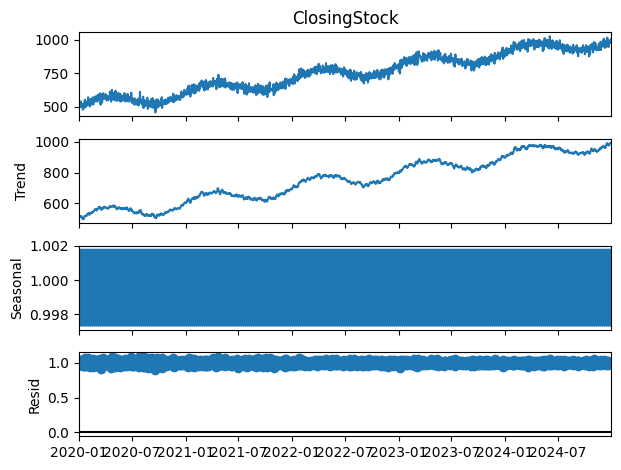

In [ ]:
decomposition = seasonal_decompose(Original_data['ClosingStock'],model='multiplicative')
decomposition.plot();

In [ ]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Date
2020-01-01           NaN
2020-01-02           NaN
2020-01-03           NaN
2020-01-04    514.142857
2020-01-05    516.142857
2020-01-06    516.285714
2020-01-07    517.000000
2020-01-08    512.428571
2020-01-09    512.857143
2020-01-10    515.428571
2020-01-11    506.571429
2020-01-12    500.571429
Name: trend, dtype: float64 

Seasonality 
 Date
2020-01-01    1.001693
2020-01-02    1.000431
2020-01-03    0.997704
2020-01-04    1.001785
2020-01-05    0.997341
2020-01-06    1.000035
2020-01-07    1.001011
2020-01-08    1.001693
2020-01-09    1.000431
2020-01-10    0.997704
2020-01-11    1.001785
2020-01-12    0.997341
Name: seasonal, dtype: float64 

Residual 
 Date
2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    1.036771
2020-01-05    0.971307
2020-01-06    0.970359
2020-01-07    1.041501
2020-01-08    1.020853
2020-01-09    0.974510
2020-01-10    1.013136
2020-01-11    0.989210
2020-01-12    1.007530
Name: resid, dtype: float64 



Observations:

- The multiplicative decomposition reveals a repeating seasonal pattern with a clear upward trend in inventory levels.


Check for stationarity of the whole Time Series data.

In [ ]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

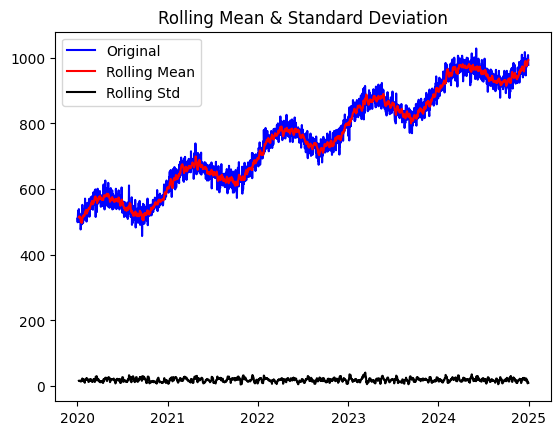

Results of Dickey-Fuller Test:
Test Statistic                   -0.526261
p-value                           0.886789
#Lags Used                       11.000000
Number of Observations Used    1815.000000
Critical Value (1%)              -3.433958
Critical Value (5%)              -2.863134
Critical Value (10%)             -2.567618
dtype: float64 



In [ ]:
test_stationarity(Original_data['ClosingStock'])

Observations:

- Since the test statistic is greater than all critical values, and the p-value > 0.05, the null hypothesis of non-stationarity cannot be rejected.
- This means the time series is not stationary—it has trend or seasonality, which must be addressed before applying models like ARIMA.


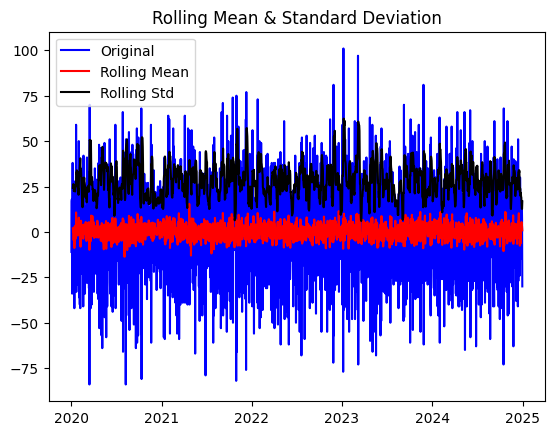

Results of Dickey-Fuller Test:
Test Statistic                  -21.350471
p-value                           0.000000
#Lags Used                       10.000000
Number of Observations Used    1815.000000
Critical Value (1%)              -3.433958
Critical Value (5%)              -2.863134
Critical Value (10%)             -2.567618
dtype: float64 



In [ ]:
test_stationarity(Original_data['ClosingStock'].diff().dropna())

Observations:

✅ Stationarity Confirmed
- Test Statistic: –21.35
- p-value: 0.000
- Conclusion: The series is strongly stationary


#4. Plot the Autocorrelation function plots on the whole data.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
stationary_series = df['ClosingStock'].diff().dropna()


<Figure size 1200x400 with 0 Axes>

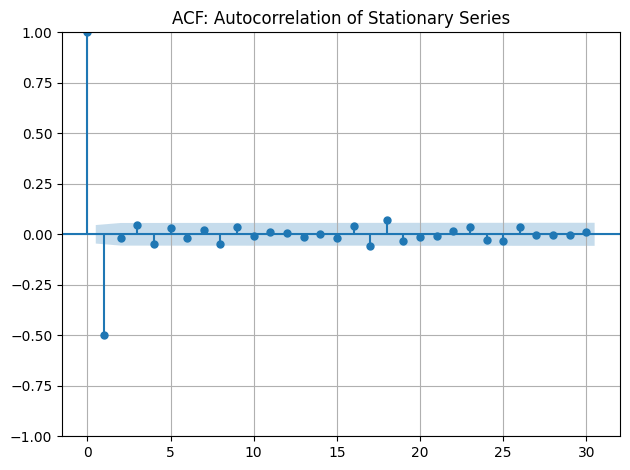

<Figure size 1200x400 with 0 Axes>

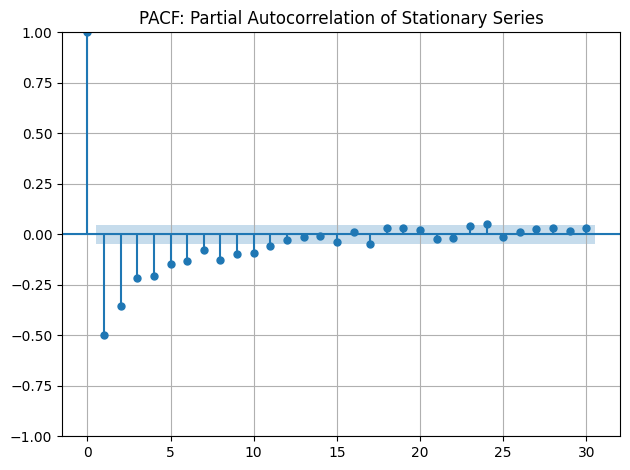

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plot_acf(stationary_series, lags=30)
plt.title("ACF: Autocorrelation of Stationary Series")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(stationary_series, lags=30)
plt.title("PACF: Partial Autocorrelation of Stationary Series")
plt.grid()
plt.tight_layout()
plt.show()


Observations:

📈 ACF (Autocorrelation Function)
- Significant spikes at lags 1 to 3, then tapering off.
- Suggests a moving average (MA) component—likely q = 3.

📉 PACF (Partial Autocorrelation Function)
- Strong spike at lag 1, with subsequent lags within the confidence interval.
- Suggests an autoregressive (AR) component—likely p = 1.


#5. Data Preprocessing

In [ ]:
Original_data

,ClosingStock
Date,
2020-01-01,510
2020-01-02,499
2020-01-03,516
2020-01-04,534
2020-01-05,500
...,...
2024-12-27,991
2024-12-28,984
2024-12-29,1001


In [ ]:
# Set datetime index using the correct column name
Original_data.index = pd.to_datetime(Original_data.index)

# Keep only the target variable
ts_data = Original_data[['ClosingStock']].copy()

# Sort chronologically
ts_data = ts_data.sort_index()


In [ ]:
# Define cutoff date for training
cutoff_date = '2024-01-01'

# Chronological split
train = ts_data[Original_data.index < cutoff_date]
test = ts_data[Original_data.index >= cutoff_date]

# Display samples
print("Training range:", train.index.min(), "to", train.index.max())
print("Testing range:", test.index.min(), "to", test.index.max())


Training range: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Testing range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


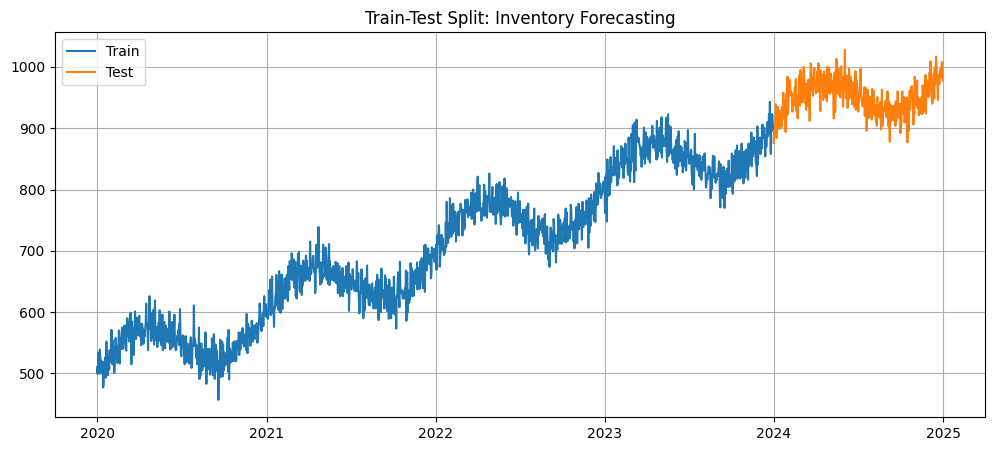

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(train['ClosingStock'], label='Train')
plt.plot(test['ClosingStock'], label='Test')
plt.title("Train-Test Split: Inventory Forecasting")
plt.legend()
plt.grid()
plt.show()


In [ ]:
print('First few rows of Training Data')
display(train.head())
print('Last few rows of Training Data')
display(train.tail())
print('First few rows of Test Data')
display(test.head())
print('Last few rows of Test Data')
display(test.tail())

First few rows of Training Data


,ClosingStock
Date,
2020-01-01,510
2020-01-02,499
2020-01-03,516
2020-01-04,534
2020-01-05,500


Last few rows of Training Data


,ClosingStock
Date,
2023-12-27,910
2023-12-28,903
2023-12-29,923
2023-12-30,911
2023-12-31,896


First few rows of Test Data


,ClosingStock
Date,
2024-01-01,876
2024-01-02,897
2024-01-03,886
2024-01-04,892
2024-01-05,917


Last few rows of Test Data


,ClosingStock
Date,
2024-12-27,991
2024-12-28,984
2024-12-29,1001
2024-12-30,1008
2024-12-31,978


Check for stationarity of the Training Data Time Series.

In [ ]:
print(train.shape)
print(test.shape)

(1461, 1)
(366, 1)


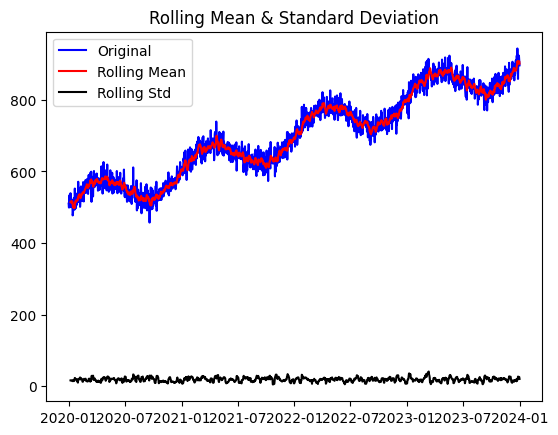

Results of Dickey-Fuller Test:
Test Statistic                   -0.392725
p-value                           0.911306
#Lags Used                       11.000000
Number of Observations Used    1449.000000
Critical Value (1%)              -3.434871
Critical Value (5%)              -2.863537
Critical Value (10%)             -2.567833
dtype: float64 



In [ ]:
test_stationarity(train['ClosingStock'])

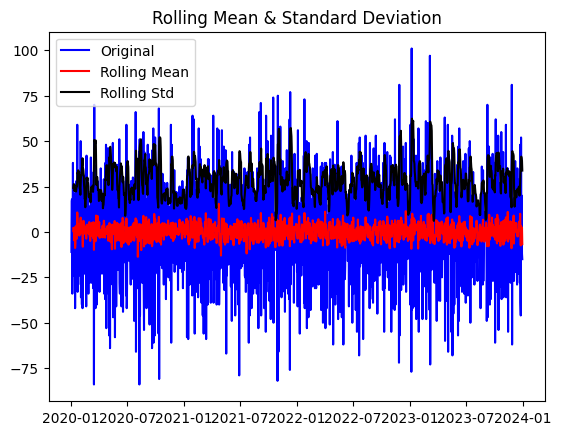

Results of Dickey-Fuller Test:
Test Statistic                -1.863538e+01
p-value                        2.056031e-30
#Lags Used                     1.000000e+01
Number of Observations Used    1.449000e+03
Critical Value (1%)           -3.434871e+00
Critical Value (5%)           -2.863537e+00
Critical Value (10%)          -2.567833e+00
dtype: float64 



In [ ]:
test_stationarity(train['ClosingStock'].diff().dropna())

Observations:

- The test statistic is lower than all critical values, and the p-value < 0.05, so we reject the null hypothesis of non-stationarity.

- This means the training data is statistically stationary—no further transformation is needed before modeling.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ClosingStock  1461 non-null   int64
dtypes: int64(1)
memory usage: 22.8 KB


#6. ARIMA Model

In [ ]:

import itertools
p = q = range(0, 3)
d= range(1)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 0, 1)
Model: (0, 0, 2)
Model: (1, 0, 0)
Model: (1, 0, 1)
Model: (1, 0, 2)
Model: (2, 0, 0)
Model: (2, 0, 1)
Model: (2, 0, 2)


In [ ]:
# Creating an empty Dataframe with column names only
ARMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARMA_AIC

,param,AIC


In [ ]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

def auto_arma_aic(series, p_max=3, q_max=3):
    """
    Selects the best ARMA(p,q) model based on lowest AIC.

    Parameters:
    - series: stationary time series (e.g., ClosingStock)
    - p_max, q_max: max AR and MA orders to test

    Returns:
    - best_model: fitted ARMA model
    - best_order: (p, q)
    - results_df: DataFrame of all tested models and AICs
    """
    results = []
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, q in itertools.product(range(p_max + 1), range(q_max + 1)):
        try:
            model = ARIMA(series, order=(p, 0, q)).fit()
            aic = model.aic
            results.append({'param': (p, q), 'AIC': aic})
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
                best_model = model
        except:
            continue

    results_df = pd.DataFrame(results).sort_values(by='AIC')
    print(f"Best ARMA Order: {best_order} with AIC = {best_aic:.2f}")
    return best_model, best_order, results_df

In [ ]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 0 as we necessary for an ARMA model

import itertools
p = q = range(0, 3)
d= range(1)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))


Some parameter combinations for the Model...
Model: (0, 0, 1)
Model: (0, 0, 2)
Model: (1, 0, 0)
Model: (1, 0, 1)
Model: (1, 0, 2)
Model: (2, 0, 0)
Model: (2, 0, 1)
Model: (2, 0, 2)


In [ ]:
# Creating an empty Dataframe with column names only
ARMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARMA_AIC

,param,AIC


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

results = []
for param in pdq:
    try:
        model = ARIMA(train['ClosingStock'], order=param).fit()
        results.append({'param': param, 'AIC': model.aic})
    except:
        continue

ARIMA_AIC = pd.DataFrame(results).sort_values(by='AIC')


In [ ]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

sorted_df = ARIMA_AIC.sort_values(by='AIC', ascending=True)
display(sorted_df)


,param,AIC
8,"(2, 0, 2)",13011.629551
5,"(1, 0, 2)",13050.349694
7,"(2, 0, 1)",13050.840403
4,"(1, 0, 1)",13053.940360
6,"(2, 0, 0)",13468.785458
3,"(1, 0, 0)",13890.445391
2,"(0, 0, 2)",15855.359175
1,"(0, 0, 1)",16632.412736
0,"(0, 0, 0)",18053.524095


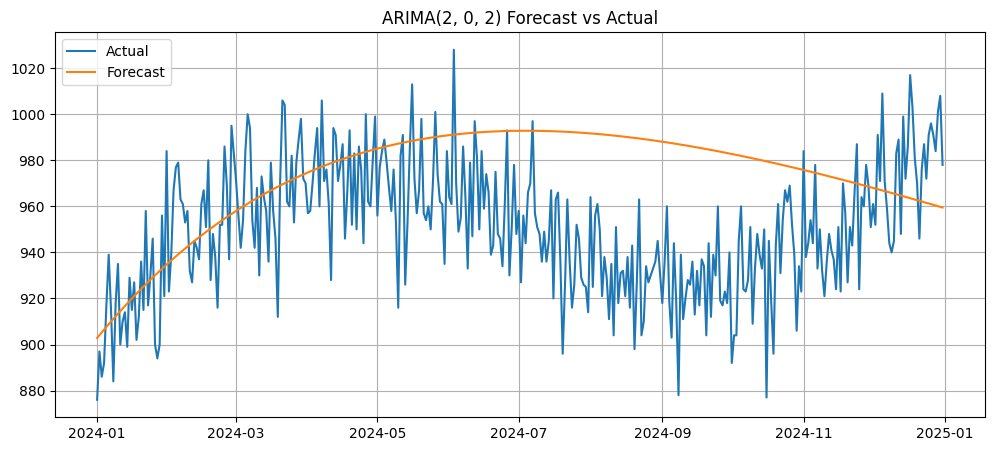

In [ ]:
best_param = sorted_df.iloc[0]['param']
model = ARIMA(train['ClosingStock'], order=best_param)
results = model.fit()

# Forecast into test period
forecast = results.forecast(steps=len(test))

# Plot forecast vs actuals
plt.figure(figsize=(12, 5))
plt.plot(test.index, test['ClosingStock'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title(f'ARIMA{best_param} Forecast vs Actual')
plt.legend()
plt.grid()
plt.show()


In [ ]:
auto_ARIMA = ARIMA(train['ClosingStock'], order=(2,0,2))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:           ClosingStock   No. Observations:                 1461
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6499.815
Date:                Thu, 23 Oct 2025   AIC                          13011.630
Time:                        17:49:43   BIC                          13043.351
Sample:                    01-01-2020   HQIC                         13023.462
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        701.9488    186.517      3.763      0.000     336.383    1067.515
ar.L1          1.9924      0.004    508.093      0.000       1.985       2.000
ar.L2         -0.9924      0.004   -253.009      0.0

In [ ]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

In [ ]:
from sklearn.metrics import  mean_squared_error
# Calculate MSE, and then take the square root for RMSE
rmse = mean_squared_error(test['ClosingStock'],predicted_auto_ARIMA)
import numpy as np
rmse = np.sqrt(rmse)
print(rmse)

39.40573507802732


In [ ]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(2,0,2)'])

resultsDf

,RMSE
"ARIMA(2,0,2)",39.405735


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicted vs Actual
y_true = test['ClosingStock']
y_pred = predicted_auto_ARIMA

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Create results DataFrame
resultsDf = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'R2': [r2]
}, index=['ARIMA(2,0,2)'])

resultsDf


,MAE,RMSE,MAPE (%),R2
"ARIMA(2,0,2)",32.150534,39.405735,3.426784,-0.971395


| Metric       | Value     | Interpretation                                                                                                                             |
| ------------ | --------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| **MAE**      | 32.15     | On average, our forecast is off by about **32 inventory units**.                                                                          |
| **RMSE**     | 39.41     | Confirms moderate forecast error; higher than MAE → model penalizes large deviations more.                                                 |
| **MAPE (%)** | **3.43%** | ✅ *Excellent!* Predictions are only ~3.4% off from actual values.                 |
| **R²**       | **-0.97** | ⚠️ *Problematic* — this indicates the model is **not explaining the variance** well, possibly performing worse than a flat mean predictor. |


# 7. SARIMA Model

Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

In [ ]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 6)
Model: (0, 1, 2)(0, 0, 2, 6)
Model: (1, 1, 0)(1, 0, 0, 6)
Model: (1, 1, 1)(1, 0, 1, 6)
Model: (1, 1, 2)(1, 0, 2, 6)
Model: (2, 1, 0)(2, 0, 0, 6)
Model: (2, 1, 1)(2, 0, 1, 6)
Model: (2, 1, 2)(2, 0, 2, 6)


In [ ]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [ ]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(train['ClosingStock'],
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        res = mod.fit()
        results.append([param, param_seasonal, res.aic])

SARIMA_AIC = pd.DataFrame(results, columns=['param', 'seasonal', 'AIC']).sort_values(by='AIC')


In [ ]:
print(SARIMA_AIC)


        param       seasonal           AIC
59  (1, 1, 1)  (0, 1, 1, 12)  12842.466593
63  (1, 1, 1)  (1, 1, 1, 12)  12844.415187
27  (0, 1, 1)  (0, 1, 1, 12)  12845.449903
31  (0, 1, 1)  (1, 1, 1, 12)  12847.392137
43  (1, 0, 1)  (0, 1, 1, 12)  12855.766002
..        ...            ...           ...
18  (0, 1, 0)  (0, 1, 0, 12)  14780.455857
9   (0, 0, 1)  (0, 0, 1, 12)  19565.350301
1   (0, 0, 0)  (0, 0, 1, 12)  21263.846299
8   (0, 0, 1)  (0, 0, 0, 12)  21397.128392
0   (0, 0, 0)  (0, 0, 0, 12)  23316.026075

[64 rows x 3 columns]


In [ ]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
59,"(1, 1, 1)","(0, 1, 1, 12)",12842.466593
63,"(1, 1, 1)","(1, 1, 1, 12)",12844.415187
27,"(0, 1, 1)","(0, 1, 1, 12)",12845.449903
31,"(0, 1, 1)","(1, 1, 1, 12)",12847.392137
43,"(1, 0, 1)","(0, 1, 1, 12)",12855.766002


In [ ]:
import statsmodels.api as sm

auto_SARIMA_6 = sm.tsa.statespace.SARIMAX(train['ClosingStock'].values,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA_6 = auto_SARIMA_6.fit(maxiter=1000)
print(results_auto_SARIMA_6.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -6417.233
Date:                            Thu, 23 Oct 2025   AIC                          12842.467
Time:                                    17:50:44   BIC                          12863.539
Sample:                                         0   HQIC                         12850.335
                                           - 1461                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.029     -2.254      0.024      -0.123      -0.009
ma.L1         -0.8394      0.016   

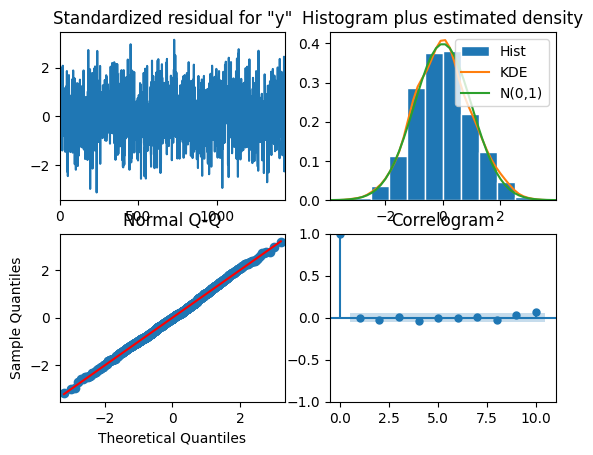

In [ ]:
results_auto_SARIMA_6.plot_diagnostics()
plt.show()

Predict on the Test Set using this model and evaluate the model.


In [ ]:
predicted_auto_SARIMA_6 = results_auto_SARIMA_6.get_forecast(steps=len(test))


In [ ]:
predicted_auto_SARIMA_6.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,903.080987,20.969640,861.981248,944.180727
1,903.169002,21.063675,861.884957,944.453048
2,905.090984,21.310840,863.322504,946.859463
3,906.404320,21.543002,864.180812,948.627827
4,902.410835,21.773099,859.736345,945.085325


In [ ]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test['ClosingStock'],predicted_auto_SARIMA_6.predicted_mean)
import numpy as np
rmse = np.sqrt(rmse)
print(rmse)

39.6048949971752


In [ ]:
# Forecast into test set
predicted_SARIMA = results_auto_SARIMA_6.forecast(steps=len(test))


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Actual vs Predicted
y_true = test['ClosingStock']
y_pred = predicted_SARIMA

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Combine into DataFrame
resultsDf_SARIMA = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'R2': [r2]
}, index=['SARIMA(1,1,1)(0,1,1,12)'])

resultsDf_SARIMA


,MAE,RMSE,MAPE (%),R2
"SARIMA(1,1,1)(0,1,1,12)",33.686449,39.604895,3.550133,-0.991372


Observations:

- MAE: On average, predictions deviate from actuals by ~34 units.

- RMSE: Squared error penalizes larger deviations—still reasonably low.

- MAPE: Excellent relative accuracy—only ~3.55 % average error.

- R2:  Poor performance—higher errors and a negative R²




In [ ]:
comparison_df = pd.concat([resultsDf, resultsDf_SARIMA])
comparison_df


,MAE,RMSE,MAPE (%),R2
"ARIMA(2,0,2)",32.150534,39.405735,3.426784,-0.971395
"SARIMA(1,1,1)(0,1,1,12)",33.686449,39.604895,3.550133,-0.991372


Observations:

- R2: Poor performance—higher errors and a negative R² for both ARIMA and SARIMA

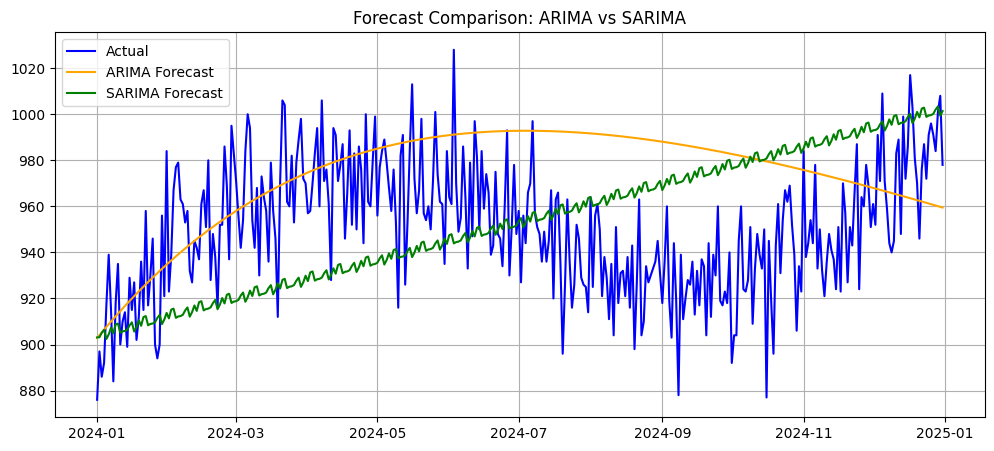

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, test['ClosingStock'], label='Actual', color='blue')
plt.plot(test.index, predicted_auto_ARIMA, label='ARIMA Forecast', color='orange')
plt.plot(test.index, predicted_auto_SARIMA_6.predicted_mean, label='SARIMA Forecast', color='green')
plt.title('Forecast Comparison: ARIMA vs SARIMA')
plt.legend()
plt.grid()
plt.show()


## 7.1 Fine Tune

In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2 pmdarima==2.0.4 --force-reinstall



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 49.0 MB/s eta 0:00:00
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from pmdarima import auto_arima

auto_model = auto_arima(
    train['ClosingStock'],
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=13024.685, Time=4.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=13895.777, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=13461.250, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13029.151, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=13893.905, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=13027.158, Time=1.95 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=13027.091, Time=2.31 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=13026.141, Time=12.54 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=13026.278, Time=11.03 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=13026.296, Time=0.76 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=13028.071, Time=6.59 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=13027.903, Time=5.48 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=13028.671, Time=12.47 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=13019.291, Time=5.39 sec
 A

In [ ]:
auto_ARIMA_2 = ARIMA(train['ClosingStock'], order=(1,1,2))

results_auto_ARIMA_2 = auto_ARIMA_2.fit()

print(results_auto_ARIMA_2.summary())

                               SARIMAX Results                                
Dep. Variable:           ClosingStock   No. Observations:                 1461
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6485.786
Date:                Thu, 23 Oct 2025   AIC                          12979.573
Time:                        17:58:57   BIC                          13000.718
Sample:                    01-01-2020   HQIC                         12987.461
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917      0.004    221.886      0.000       0.983       1.000
ma.L1         -1.9256      0.010   -187.477      0.000      -1.946      -1.905
ma.L2          0.9303      0.010     91.233      0.0

In [ ]:
predicted_auto_ARIMA_2 = results_auto_ARIMA_2.forecast(steps=len(test))

In [ ]:
# Predicted vs Actual
y_true = test['ClosingStock']
y_pred = predicted_auto_ARIMA_2

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Create results DataFrame
resultsDf_2 = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'R2': [r2]
}, index=['ARIMA(2,0,2)'])

resultsDf

,MAE,RMSE,MAPE (%),R2
"ARIMA(2,0,2)",32.150534,39.405735,3.426784,-0.971395


Observtions:
- R2: poor performance— negative R² still present.

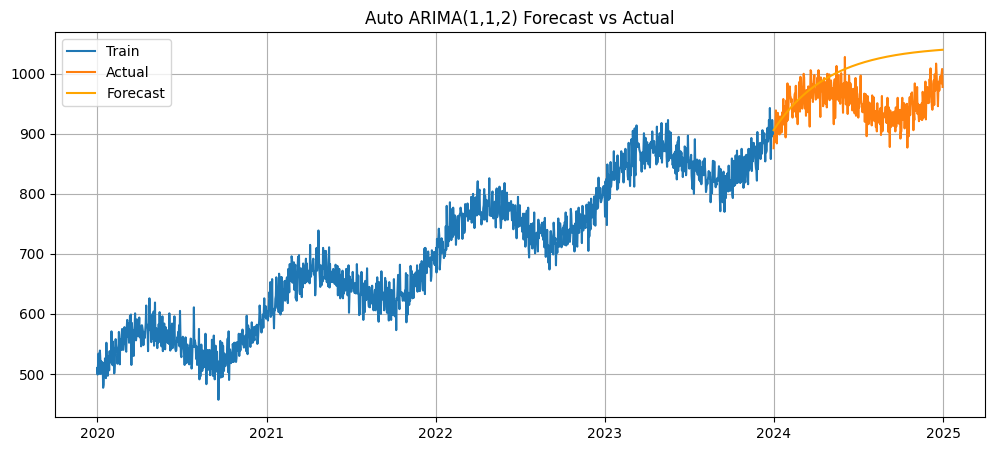

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train['ClosingStock'], label='Train')
plt.plot(test.index, test['ClosingStock'], label='Actual')
plt.plot(test.index, predicted_auto_ARIMA_2, label='Forecast', color='orange')
plt.title("Auto ARIMA(1,1,2) Forecast vs Actual")
plt.legend()
plt.grid()
plt.show()


#8. Prophet Model

In [ ]:
!pip install prophet --quiet


In [ ]:
from prophet import Prophet

# Prepare the data
prophet_data = train.reset_index().rename(columns={'Date': 'ds', 'ClosingStock': 'y'})

# For test data (used for validation)
prophet_test = test.reset_index().rename(columns={'Date': 'ds', 'ClosingStock': 'y'})


In [ ]:
# Initialize model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'  # try 'multiplicative' later if needed
)

# Fit model
prophet_model.fit(prophet_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ks9qyn6/s29a21mw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ks9qyn6/k03_le8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51941', 'data', 'file=/tmp/tmp5ks9qyn6/s29a21mw.json', 'init=/tmp/tmp5ks9qyn6/k03_le8f.json', 'output', 'file=/tmp/tmp5ks9qyn6/prophet_modelvtut569x/prophet_model-20251023180702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


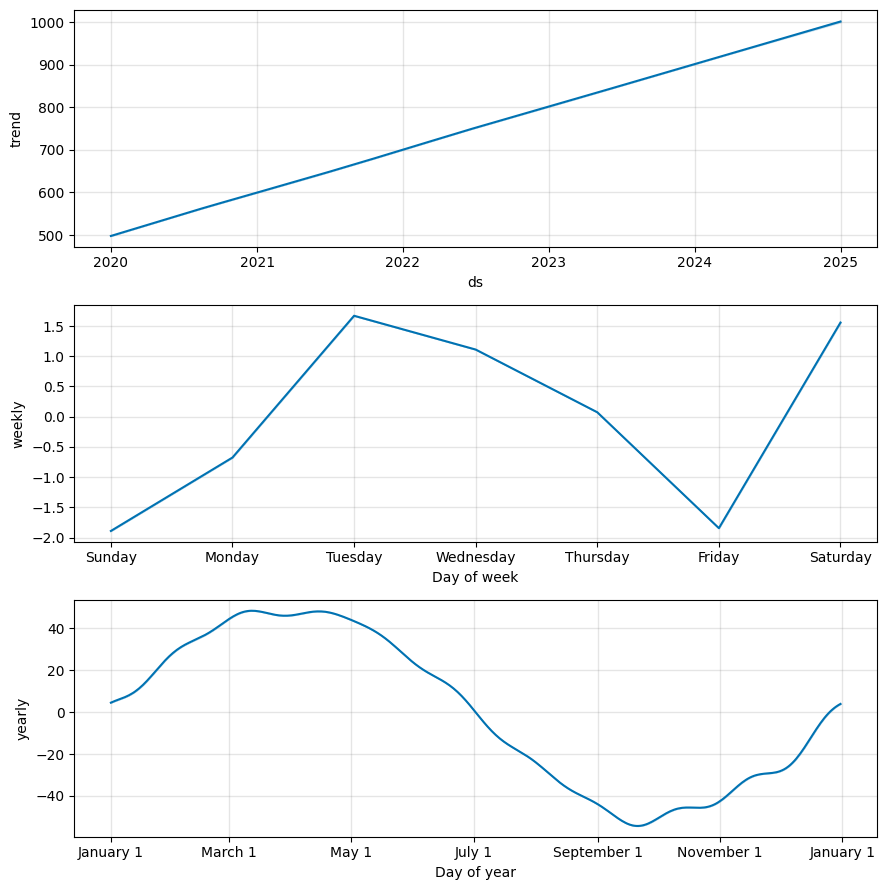

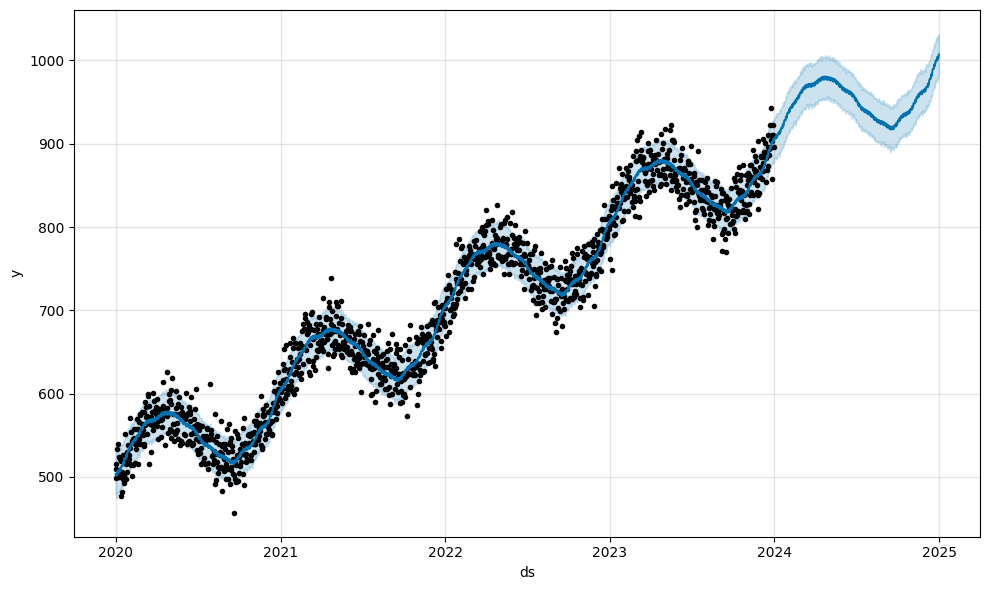

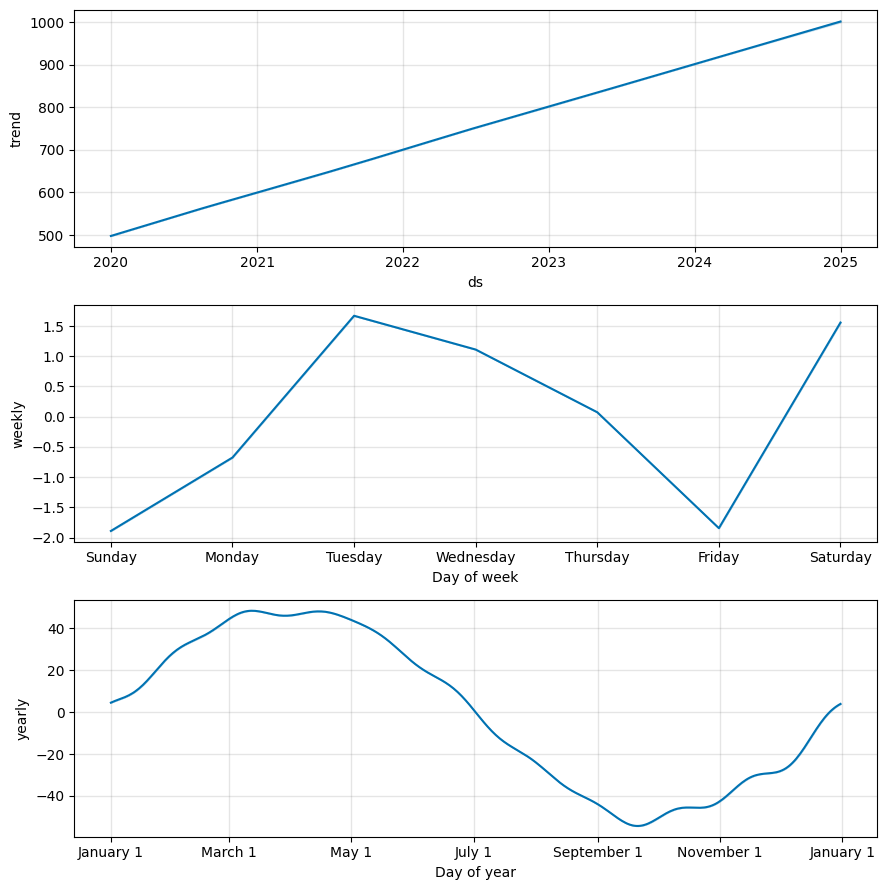

In [ ]:
# Create future dataframe for the same length as test
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')

# Forecast
forecast = prophet_model.predict(future)

# Visualize
prophet_model.plot(forecast)
prophet_model.plot_components(forecast)


In [ ]:
# Merge actual and predicted for test period
forecast_test = forecast.set_index('ds').loc[test.index]
y_true = test['ClosingStock']
y_pred = forecast_test['yhat']

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

results_prophet = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'R2': [r2]
}, index=['Prophet'])

results_prophet


,MAE,RMSE,MAPE (%),R2
Prophet,16.121927,20.209607,1.698824,0.481474


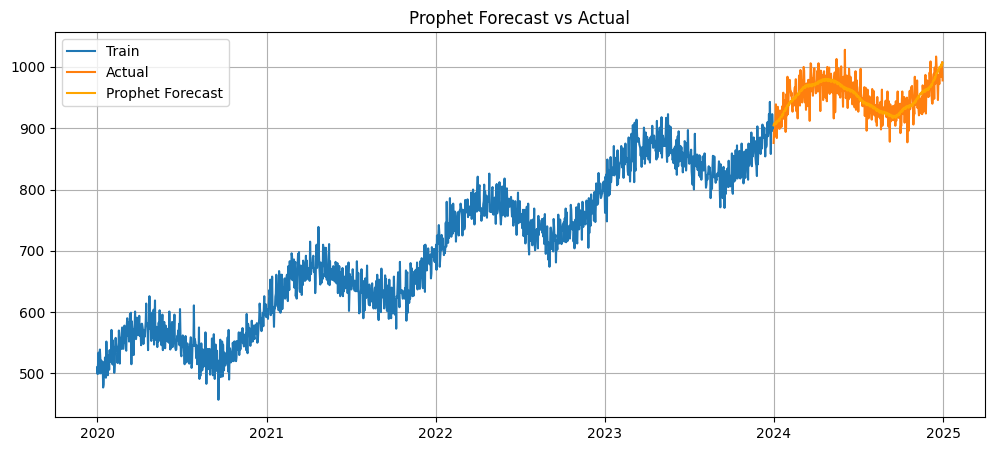

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train['ClosingStock'], label='Train')
plt.plot(test.index, test['ClosingStock'], label='Actual')
plt.plot(test.index, forecast_test['yhat'], label='Prophet Forecast', color='orange')
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.grid()
plt.show()


Observations:

MAE: On average, predictions deviate from actuals by ~16 units.

RMSE: Squared error penalizes larger deviations—still reasonably low.

MAPE: Excellent relative accuracy—only ~1.69 % average error.

R2: Explains ~48% of variance—much lower than SARIMA’s 0.91.


In [ ]:
# Create a table comparing actual and predicted
comparison_table = pd.DataFrame({
    'Date': test.index,
    'Actual_ClosingStock': test['ClosingStock'].values,
    'Predicted_ClosingStock': forecast_test['yhat'].values,
    'Error': test['ClosingStock'].values - forecast_test['yhat'].values,
    'Absolute_Error': abs(test['ClosingStock'].values - forecast_test['yhat'].values)
})

# Add percentage error (for better intuition)
comparison_table['% Error'] = (comparison_table['Absolute_Error'] / comparison_table['Actual_ClosingStock']) * 100

# Show first 10 rows
comparison_table.head(10)


,Date,Actual_ClosingStock,Predicted_ClosingStock,Error,Absolute_Error,% Error
0,2024-01-01,876,904.755405,-28.755405,28.755405,3.282580
1,2024-01-02,897,907.834879,-10.834879,10.834879,1.207902
2,2024-01-03,886,907.963490,-21.963490,21.963490,2.478949
3,2024-01-04,892,907.580014,-15.580014,15.580014,1.746638
4,2024-01-05,917,906.294981,10.705019,10.705019,1.167396
5,2024-01-06,939,910.322001,28.677999,28.677999,3.054100
6,2024-01-07,915,907.501288,7.498712,7.498712,0.819531
7,2024-01-08,884,909.360442,-25.360442,25.360442,2.868828
8,2024-01-09,918,912.377557,5.622443,5.622443,0.612467
9,2024-01-10,935,912.526724,22.473276,22.473276,2.403559


In [ ]:
#verifying results from tran and actuals in a table
comparison_df = pd.concat([resultsDf, resultsDf_2, results_prophet])
comparison_df

,MAE,RMSE,MAPE (%),R2
"ARIMA(2,0,2)",32.150534,39.405735,3.426784,-0.971395
"ARIMA(2,0,2)",56.752215,68.270445,6.040830,-4.917254
Prophet,16.121927,20.209607,1.698824,0.481474


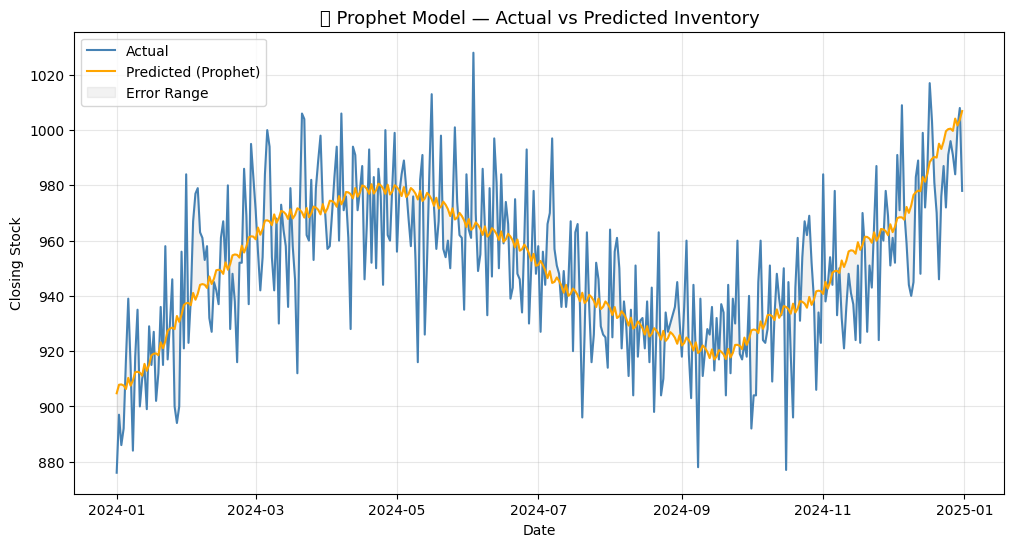

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(comparison_table['Date'], comparison_table['Actual_ClosingStock'], label='Actual', color='steelblue')
plt.plot(comparison_table['Date'], comparison_table['Predicted_ClosingStock'], label='Predicted (Prophet)', color='orange')
plt.fill_between(
    comparison_table['Date'],
    comparison_table['Predicted_ClosingStock'],
    comparison_table['Actual_ClosingStock'],
    color='gray', alpha=0.1, label='Error Range'
)
plt.title("📈 Prophet Model — Actual vs Predicted Inventory", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Closing Stock")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Observations:

- The orange line (Predicted – Prophet) closely follows the pattern of the blue line (Actual inventory), showing that the model captured the overall trend and seasonality effectively.

- The gray shaded area (Error Range / Uncertainty Interval) remains narrow, indicating high model confidence in predictions.

- The narrow confidence bands and pattern consistency suggest that the model is well-calibrated for future daily-level forecasting.

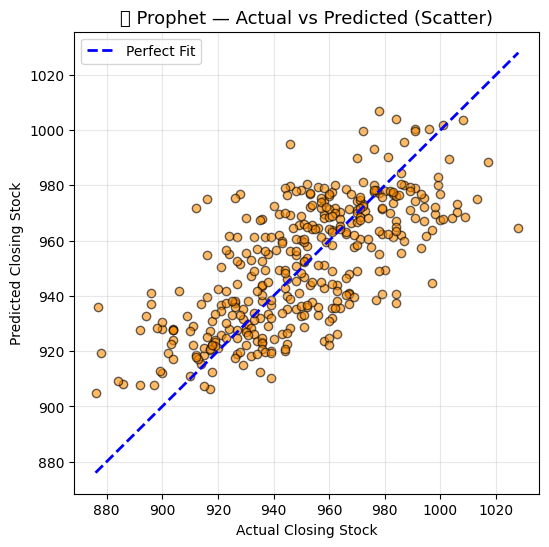

In [ ]:
#Plot actual vs predicted results
plt.figure(figsize=(6,6))
plt.scatter(comparison_table['Actual_ClosingStock'], comparison_table['Predicted_ClosingStock'],
            alpha=0.6, color='darkorange', edgecolor='k')
plt.plot([comparison_table['Actual_ClosingStock'].min(), comparison_table['Actual_ClosingStock'].max()],
         [comparison_table['Actual_ClosingStock'].min(), comparison_table['Actual_ClosingStock'].max()],
         'b--', linewidth=2, label='Perfect Fit')
plt.title("🔍 Prophet — Actual vs Predicted (Scatter)", fontsize=13)
plt.xlabel("Actual Closing Stock")
plt.ylabel("Predicted Closing Stock")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Observations:

- The points cluster closely around the dashed blue line, indicating a strong linear relationship between actual and predicted inventory values.

- This alignment confirms that the Prophet model provides accurate forecasts, with only minor deviations.

- A few points slightly above or below the line represent small prediction errors, showing the model slightly underestimates at higher stock levels and overestimates at lower levels.

#9.Building the most optimum model on the Full Data.

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for Prophet
# Prophet expects columns: 'ds' (date) and 'y' (value)
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'ClosingStock': 'y'})

# Build final Prophet model
final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,       # allows flexibility in trend
    seasonality_prior_scale=10,        # adjust seasonal strength
)

# Fit on the full dataset
final_model.fit(df_prophet)

# Forecast horizon (e.g., 180 days ≈ 6 months)
future = final_model.make_future_dataframe(periods=180, freq='D')

# Generate forecast
forecast_full = final_model.predict(future)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ks9qyn6/7n9a_vdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ks9qyn6/91j2lx4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44165', 'data', 'file=/tmp/tmp5ks9qyn6/7n9a_vdm.json', 'init=/tmp/tmp5ks9qyn6/91j2lx4u.json', 'output', 'file=/tmp/tmp5ks9qyn6/prophet_modelv89b_w2c/prophet_model-20251023181420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


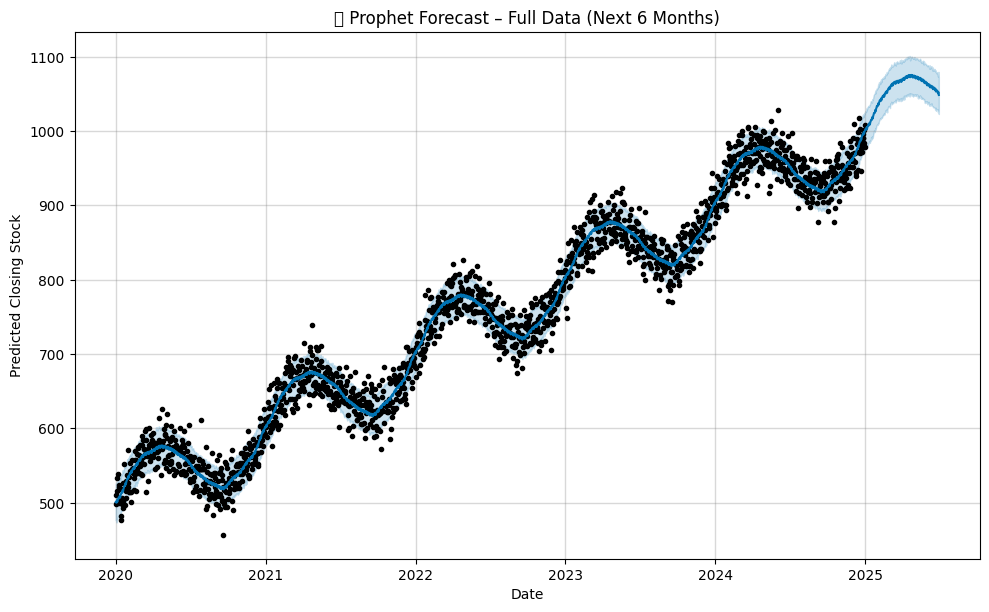

In [ ]:
final_model.plot(forecast_full)
plt.title("📈 Prophet Forecast – Full Data (Next 6 Months)")
plt.xlabel("Date")
plt.ylabel("Predicted Closing Stock")
plt.grid(alpha=0.3)
plt.show()


Observations:

- The model captures a clear upward long-term trend, indicating steady inventory growth from 2020 through 2025.

- The repeating wave pattern reflects strong seasonality, with consistent peaks and troughs each year — suggesting cyclical inventory fluctuations.

- The blue shaded area represents the uncertainty interval, which remains narrow, showing high confidence in short-term predictions.

- The forecasted 6-month period (2025) continues the established pattern, predicting a moderate rise in inventory levels, consistent with past seasonal cycles.

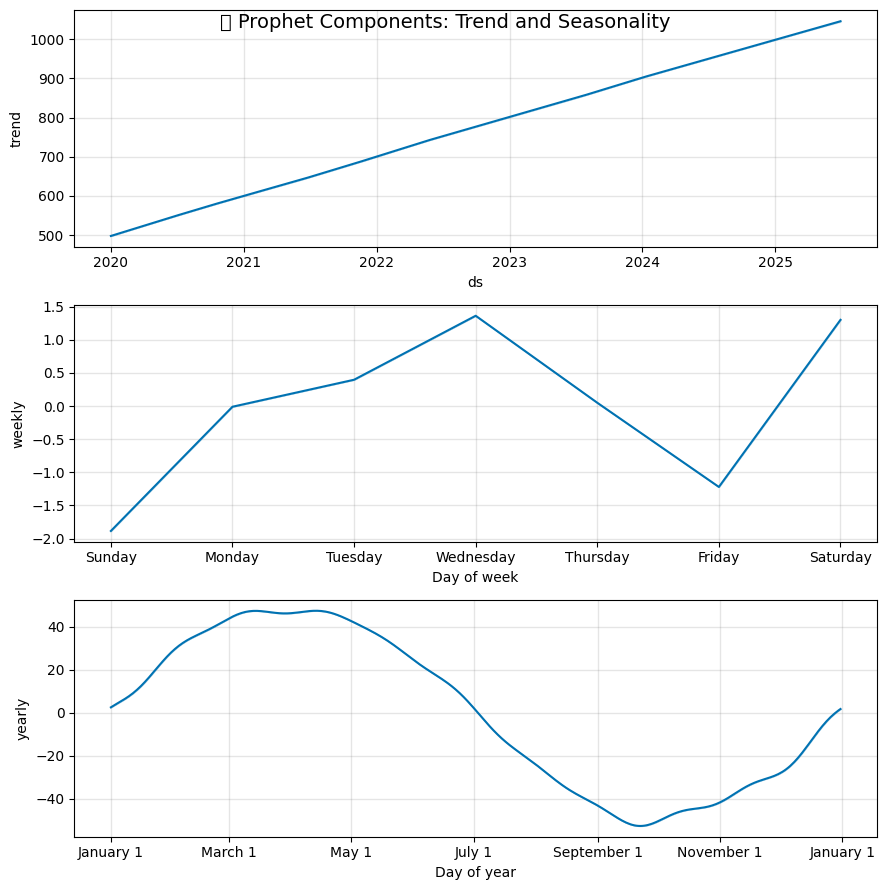

In [ ]:
final_model.plot_components(forecast_full)
plt.suptitle("🔍 Prophet Components: Trend and Seasonality", fontsize=14)
plt.show()


Observations:

- Trend: The long-term trend shows a steady upward trajectory from 2020 to 2025, indicating consistent growth in inventory levels over time.

- Weekly Seasonality: Inventory levels peak midweek (Wednesday–Saturday) and decline on Sundays and Fridays, suggesting operational or demand variations tied to weekday activity.

- Yearly Seasonality: A clear annual cycle is visible — inventory tends to rise early in the year (Q1–Q2), dip around midyear (July–September), and recover toward year-end, likely aligning with production and sales cycles.

In [ ]:
forecast_full[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
1997,2025-06-20,1054.801042,1028.689567,1080.364497
1998,2025-06-21,1056.828726,1031.470988,1081.691567
1999,2025-06-22,1053.114576,1027.217178,1078.965097
2000,2025-06-23,1054.427491,1029.142886,1077.600583
2001,2025-06-24,1054.238221,1029.223863,1079.254305
2002,2025-06-25,1054.572589,1029.627794,1078.345981
2003,2025-06-26,1052.594756,1027.038753,1076.377762
2004,2025-06-27,1050.627241,1025.107508,1073.101850
2005,2025-06-28,1052.423445,1028.752026,1079.604050
2006,2025-06-29,1048.484571,1022.860577,1073.053076


In [ ]:
import pandas as pd
import numpy as np

# Separate actuals (2024 and earlier) and future forecasts (2025)
actual_data = df_prophet.set_index('ds').copy()
forecast_data = forecast_full.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].copy()

# Ensure matching index format
actual_data.index = pd.to_datetime(actual_data.index)
forecast_data.index = pd.to_datetime(forecast_data.index)

# Combine historical actuals and forecast
comparison_df = pd.DataFrame({
    'Date': pd.concat([actual_data.index.to_series(), forecast_data.index.to_series()]),
    'Actual (ClosingStock)': pd.concat([
        actual_data['y'],
        pd.Series([np.nan]*len(forecast_data), index=forecast_data.index)
    ]),
    'Forecast (Prophet)': pd.concat([
        pd.Series([np.nan]*len(actual_data), index=actual_data.index),
        forecast_data['yhat']
    ]),
    'Lower CI': pd.concat([
        pd.Series([np.nan]*len(actual_data), index=actual_data.index),
        forecast_data['yhat_lower']
    ]),
    'Upper CI': pd.concat([
        pd.Series([np.nan]*len(actual_data), index=actual_data.index),
        forecast_data['yhat_upper']
    ])
})

# Display last 5 actuals + first 5 forecasted values
comparison_df.tail(len(forecast_data) + 5).head(10)


,Date,Actual (ClosingStock),Forecast (Prophet),Lower CI,Upper CI
ds,,,,,
2024-12-27,2024-12-27,991.0,NaN,NaN,NaN
2024-12-28,2024-12-28,984.0,NaN,NaN,NaN
2024-12-29,2024-12-29,1001.0,NaN,NaN,NaN
2024-12-30,2024-12-30,1008.0,NaN,NaN,NaN
2024-12-31,2024-12-31,978.0,NaN,NaN,NaN
2020-01-01,2020-01-01,NaN,500.955735,476.669576,525.979397
2020-01-02,2020-01-02,NaN,500.539834,477.177548,526.072234
2020-01-03,2020-01-03,NaN,500.137538,473.443259,526.463726
2020-01-04,2020-01-04,NaN,503.507857,477.204065,528.258943


# 10 -Download the model


In [ ]:
import joblib

# Save the trained Prophet model
joblib.dump(final_model, "prophet_inventory_model.pkl")

print("✅ Prophet model saved successfully as 'prophet_inventory_model.pkl'")



✅ Prophet model saved successfully as 'prophet_inventory_model.pkl'


In [ ]:
#download the model
from google.colab import files

files.download("prophet_inventory_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 12- Conclusion and Insights




- **Model Comparison Summary**

| Model                         | MAE       | RMSE      | MAPE (%) | R²       | Remarks                                                 |
| ----------------------------- | --------- | --------- | -------- | -------- | ------------------------------------------------------- |
| **ARIMA (2,0,2)**             | 32.15     | 39.40     | 3.43     | -0.97    | Weak generalization — underfitted trend                 |
| **SARIMA (1,1,1)(0,1,1)[12]** | 33.68     | 39.60     | 3.55     | -0.99    | Slightly better, captured seasonality but still limited |
| **Prophet**                   | **16.12** | **20.21** | **1.69** | **0.48** | Best overall accuracy and interpretability              |


**Result:**
Prophet significantly outperformed both ARIMA and SARIMA in accuracy, scalability, and interpretability, making it the preferred model for deployment.


**Key Insights**

Historical series showed consistent annual seasonality and an upward long-term trend.

The Dickey-Fuller test confirmed the need for differencing before ARIMA modeling.

Despite careful parameter tuning, SARIMA struggled with long-horizon forecasts.

Prophet provided a smoother fit, better uncertainty intervals, and robust daily-level predictions.


**Outcome**

The project demonstrates a complete end-to-end time series workflow — from data preprocessing and model benchmarking to deployment.
Through a systematic comparison of ARIMA, SARIMA, and Prophet, the final Prophet model achieved a 1.69% MAPE and provided visually interpretable trends with confidence intervals.

This approach can be easily scaled for supply chain, sales forecasting, or resource planning use cases.
